In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import torch
import torch.nn as nn
import os
import time

from random import shuffle
from scipy.stats import gamma, beta, nbinom, poisson
from scipy.special import gammaln, betaln
from torch.autograd import Variable
import sys 
sys.path.append('../')
from utils import *

%matplotlib inline

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['figure.figsize'] = (15, 5)

## Generate Poisson data, compare Poisson vs. negBin model

I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial sampled from a Poisson-Gamma mixture with Gamma priors on the Gamma shape and scale parameters. 

As training data I will generate a large data set containing samples from both models generated with the corresponding priors. The MDN gets the mean and variance of the data set as input and outputs a probability vector over models. 

### Controlling difficulty via over / under dispersion 
The prior parameters of the conjugate Gamma prior of the Poisson model and the two Gamma priors of the NB model are chosen such that on average the data sets generated by the models have idenitcal sample means. The difficulty therefore arises from the amount of overdispersion in the NB model: The model comparison problem becomes easier to solve as the variance in the samples form the NB model is larger than the mean. 

In [2]:
sample_size = 100
n_samples = 10000

# set RNG
seed = 2
np.random.seed(seed)

time_stamp = time.strftime('%Y%m%d%H%M_')
figure_folder = '../figures/'

# set prior parameters 
# set the shape or scale of the Gamma prior for the Poisson model
k1 = 9.0 
# set the shape and scale of the prior on the shape of the Gamma for the mixture to be broad 
theta2 = 2.0
k2 = 5.
# set the shape and scale of the prior on the scale of the Gamma for the mixture to be small 
# this will make the variance and could be the tuning point of the amount of overdispersion / difficulty
theta3 = 1.0 
k3 = 1

# then the scale of the Gamma prior for the Poisson is given by 
theta1 = (k2 * theta2 * k3 * theta3) / k1
print(theta1, k1)

# get analytical means 
mean_ana_poi = k1 * theta1
mean_ana_nb = k2 * k3 * theta2 * theta3

# set the priors 
prior_lam = scipy.stats.gamma(a=k1, scale=theta1)
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

1.1111111111111112 9.0


In [3]:
# generate a large data set for training 

X = []
thetas = []
m = []

for sample_idx in range(n_samples): 
    
    # sample model index 
    m.append(int(np.round(np.random.rand())))
    
    if m[sample_idx] == 0: 
        # sample poisson 
        theta, x = sample_poisson(prior_lam, 1, sample_size)
    if m[sample_idx] == 1: 
        # sample poisson 
        theta, x, lambs = sample_poisson_gamma_mixture(prior_k, prior_theta, 1, sample_size)

    # calculate mean and var as summary stats 
    X.append([np.mean(x), np.var(x)])
    thetas.append(theta)
    
X = np.array(X)

## Define network for fitting the model posterior

In [4]:
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=2, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m
    
def train_psi(X, Y, model, optim, lossfun, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))        
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [5]:
# normalize 
X, norm = normalize(X)

In [6]:
n_inputs = 2
model = MDN_psi(ndim_input=n_inputs, n_hidden=10)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lossfun = nn.CrossEntropyLoss()

model_psi, optim_psi, losses = train_psi(X, m, model, optim, lossfun, n_epochs=200, n_minibatch=50)

[epoch 0100] loss: 0.0789
[epoch 0200] loss: 0.0591


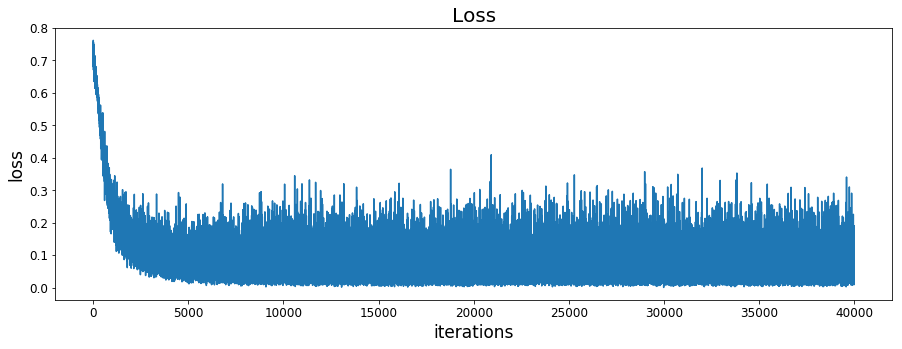

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Visualize input-output function of the network

In [8]:
x, y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 100, 100))

In [9]:
ppoi_mat = np.zeros((100, 100))
softmax = nn.Softmax(dim=0)

for i in range(x.shape[0]): 
    for j in range(x.shape[0]): 
        stats_o, norm = normalize(np.array([x[i, j], y[i, j]]), norm)        
        (out_act) = model(Variable(torch.Tensor(stats_o)))
    
        # in this vector, index 0 is Poi, index 1 is NB
        posterior_probs = softmax(out_act).data.numpy()
        ppoi_mat[i, j] = posterior_probs[0]

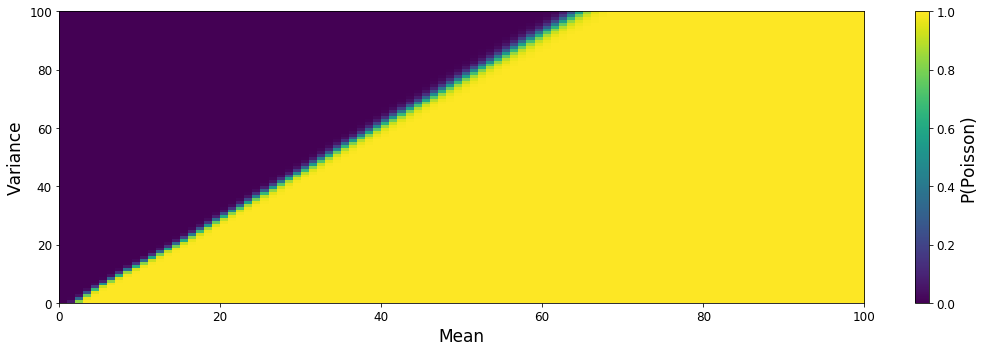

In [10]:
plt.imshow(ppoi_mat, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.colorbar(label='P(Poisson)');
plt.tight_layout()
save_figure(filename='network_visualization_2d_M{}N{}'.format(sample_size, n_samples), 
            folder=figure_folder, 
            time_stamp=time_stamp)

## Make predictions with test data 

In [11]:
# generate test data from both models
testX = []
testSX = []
thetas = []
m = []
n_samples = 10
sample_size = sample_size
markers = []
lambs = []

for sample_idx in range(n_samples): 
    
    # sample model index 
    m.append(int(np.round(np.random.rand())))
    
    if m[sample_idx] == 0: 
        # sample poisson 
        theta, x = sample_poisson(prior_lam, 1, sample_size)
        markers.append('x')
    if m[sample_idx] == 1: 
        # sample poisson 
        theta, x, ls = sample_poisson_gamma_mixture(prior_k, prior_theta, 1, sample_size)
        markers.append('o')
        lambs.append(ls)

    # calculate mean and var as summary stats 
    testX.append(x)
    testSX.append([np.mean(x), np.var(x)])
    thetas.append(theta)
    
testX = np.array(testX).squeeze()
lambs = np.array(lambs)
testSX = np.array(testSX)
testm = m

In [12]:
test_ppoi = []
for xtest in testSX: 
    stats_o, norm = normalize(xtest, norm)        
    (out_act) = model(Variable(torch.Tensor(stats_o)))

    # in this vector, index 0 is Poi, index 1 is NB
    test_ppoi.append(softmax(out_act).data.numpy()[0])    

test_ppoi = np.array(test_ppoi)
test_ppoi[test_ppoi == 1.] = 0.999
lbf_pred = np.log(test_ppoi) - np.log(1 - test_ppoi)

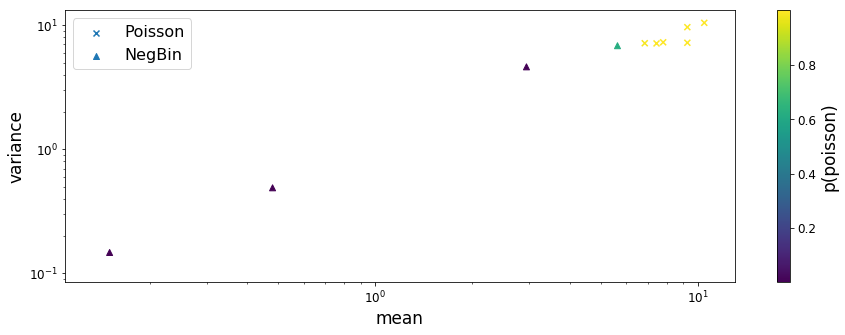

In [13]:
poi_mask = np.array(testm) == 0
nb_mask = np.logical_not(poi_mask)
x, y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 100, 100))

# color norm 
colornorm = mpl.colors.Normalize(vmin=test_ppoi.min(), vmax=test_ppoi.max())

plt.scatter(x=testSX[poi_mask, 0], y=testSX[poi_mask, 1], 
            cmap='viridis', c=test_ppoi[poi_mask], marker='x', 
           label='Poisson', norm=colornorm)
plt.scatter(x=testSX[nb_mask, 0], y=testSX[nb_mask, 1], 
            cmap='viridis', c=test_ppoi[nb_mask], marker='^', label='NegBin', norm=colornorm)

plt.colorbar(label='p(poisson)', orientation='vertical')
plt.xlabel('mean')
plt.ylabel('variance')
#plt.contour(x, y, ppoi_mat)
plt.yscale('log')
plt.xscale('log')
plt.legend();

## Compare network predictions to analytical posterior probabilities

The network outputs a vector of posterior model probabilities. Ideally, we have the same values in analytical form. Up to now we just derived the analytical form of the individual model evidences and from that the analytical Bayes factor. This we can compare to the predicted posterior probability because we have a uniform model prior. With a uniform model prior $(p(M_1) = p(M_2))$ the posterior ratio is the same as the evidence ration (Bayes factor):

\begin{align}
BayesFactor = \frac{p(D | M_1)}{p(D | M_2)} = \frac{p(M_1 | D) p(M_1)}{p(M_2 | D) p(M_2)} = \frac{p(M_1 | D)}{p(M_2 | D)}
\end{align}

Thus, we can just calculate the individual model evidences and compare their ratio to the ratio of the output of the network. 

Alternatively, we can derive the analytical posterior probabilities for each model and compare it directly to the probabilities predicted by the network. 

\begin{align}
p(M_i | D) &= \frac{p(D|M_i)p(M_i)}{p(D)} \\
&= \frac{p(D|M_i)p(M_i)}{\sum_j^{|M|} p(D | M_j)} \\ 
&= \frac{\int p(D|\theta)p(\theta|M_i)d\theta \; p(M_i)}{\sum_j^{|M|} \int p(D|\theta)p(\theta|M_j)d\theta}
\end{align}

In [14]:
# set up a grid of values around the priors 
# take grid over the whole range of the priors
k_start = scipy.stats.gamma.ppf(1e-8, a=k2)
k_end = scipy.stats.gamma.ppf(1 - 1e-8, a=k2)

theta_start = scipy.stats.gamma.ppf(1e-8, a=k3)
theta_end = scipy.stats.gamma.ppf(1 - 1e-8, a=k3)

In [20]:
# calculate nb evidence for every test set 
nb_evidences = []
poi_evidences = []

for ii, (x, mi) in enumerate(zip(testX, testm)):
    (lquad, err) = scipy.integrate.dblquad(func=nb_evidence_integrant_direct,
                                           a=theta_start / (1 + theta_start),
                                           b=theta_end / (1 + theta_end),
                                           gfun=lambda x: k_start, hfun=lambda x: k_end, 
                                           args=[x, prior_k, prior_theta])
    print(mi, 'NB', np.log(lquad))
    nb_evidences.append(np.log(lquad))

    le = poisson_evidence(x, k=k1, theta=theta1, log=True)
    print(mi, 'Poi', le)
    poi_evidences.append(le)

1 NB -209.975492687
1 Poi -217.796110933
0 NB -245.655988162
0 Poi -241.719268289
0 NB -247.968717087
0 Poi -242.196596448
0 NB -268.088427795
0 Poi -260.924890461
0 NB -255.758251328
0 Poi -245.760528035
0 NB -262.382985561
0 Poi -256.482197478
1 NB -239.034357625
1 Poi -238.535452541
1 NB -48.614221229
1 Poi -71.3784374131
0 NB -249.513011042
0 Poi -243.018702149
1 NB -95.4493226955
1 Poi -110.523222431


In [21]:
poi_evidences = np.array(poi_evidences)
nb_evidences = np.array(nb_evidences)
lbf_ana = poi_evidences - nb_evidences
ppoi_ana = calculate_pprob_from_evidences(np.exp(poi_evidences), np.exp(nb_evidences))

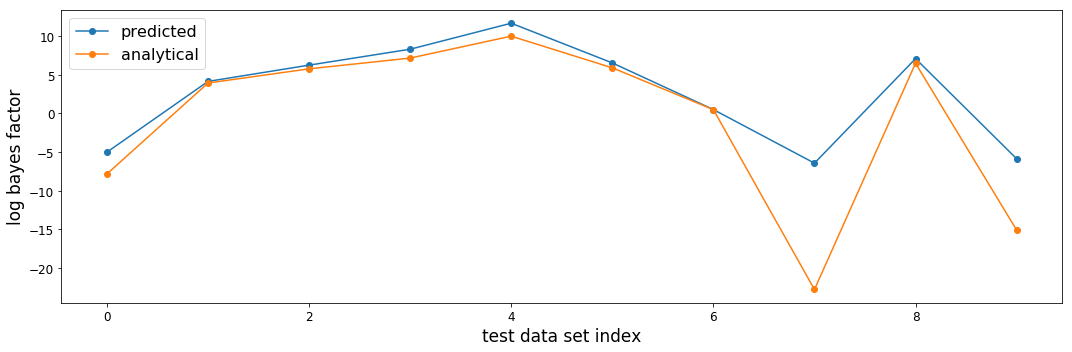

In [22]:
plt.plot(lbf_pred, 'o-', label='predicted')
plt.plot(lbf_ana, 'o-', label='analytical')
plt.xlabel('test data set index')
plt.ylabel('log bayes factor')
plt.legend();
plt.tight_layout()
save_figure(filename='bayesfactor_prediction_evaluation_M{}N{}'.format(sample_size, n_samples), 
            folder=figure_folder, 
            time_stamp=time_stamp)

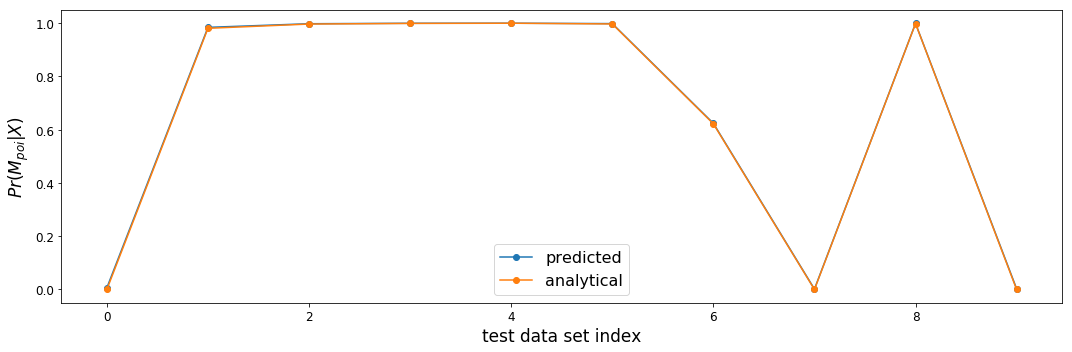

In [23]:
plt.plot(test_ppoi, 'o-', label='predicted')
plt.plot(ppoi_ana, 'o-', label='analytical')
plt.xlabel('test data set index')
plt.ylabel(r'$Pr(M_{poi} | X)$')
plt.legend();
plt.tight_layout()
save_figure(filename='posterior_prediction_evaluation_M{}N{}'.format(sample_size, n_samples), 
            folder=figure_folder, 
            time_stamp=time_stamp)